In [341]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import torchvision.models.quantization as models
import matplotlib.pyplot as plt
import time
import os
import shutil
from PIL import Image
import dlib
import cv2

plt.ion()

In [135]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '.'
x = 'train'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)}

dataset_sizes = {x: len(image_datasets[x])}
class_names = image_datasets['train'].classes

# use_gpu = torch.cuda.is_available()

In [136]:
print(dataset_sizes)

{'train': 20870}


In [137]:
use_gpu

True

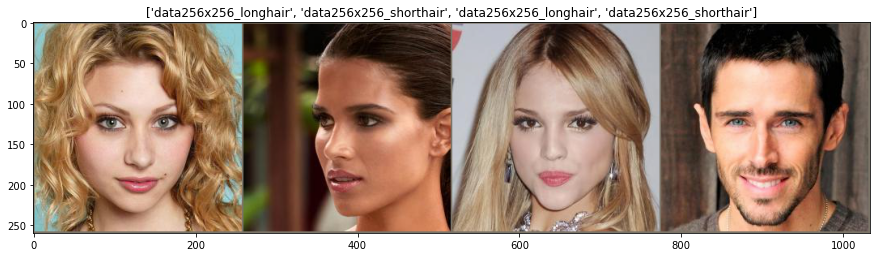

In [138]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

    
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [139]:
for i in dataloaders['train']:
    print(i[0][0])
    break

tensor([[[-2.0152, -2.0323, -2.0494,  ..., -2.0665, -2.0665, -2.0665],
         [-2.0152, -2.0323, -2.0494,  ..., -2.0665, -2.0665, -2.0665],
         [-2.0152, -2.0323, -2.0494,  ..., -2.0665, -2.0665, -2.0665],
         ...,
         [-2.0323, -2.0323, -1.9980,  ..., -2.0494, -2.0494, -2.0323],
         [-1.9980, -1.9980, -1.9980,  ..., -2.0837, -2.1008, -2.0837],
         [-1.9638, -1.9980, -1.9980,  ..., -2.1008, -2.1008, -2.1179]],

        [[-1.8957, -1.9132, -1.9307,  ..., -1.9832, -1.9832, -1.9832],
         [-1.8957, -1.9132, -1.9307,  ..., -1.9832, -1.9832, -1.9832],
         [-1.8957, -1.9132, -1.9307,  ..., -1.9832, -1.9832, -1.9832],
         ...,
         [-1.9657, -1.9657, -1.9307,  ..., -1.9307, -1.8782, -1.8606],
         [-1.9307, -1.9307, -1.9307,  ..., -1.9132, -1.9132, -1.8957],
         [-1.8957, -1.9307, -1.9307,  ..., -1.9132, -1.9132, -1.9132]],

        [[-1.7173, -1.7347, -1.7522,  ..., -1.7522, -1.7522, -1.7522],
         [-1.7173, -1.7347, -1.7522,  ..., -1

In [327]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, losses

In [328]:
def create_combined_model(model_fe):
    model_fe_features = nn.Sequential(
        model_fe.quant,
        model_fe.conv1,
        model_fe.maxpool,
        model_fe.stage2,
        model_fe.stage3,
        model_fe.stage4,
        model_fe.conv5,
        model_fe.dequant,
    )

    new_head = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(65536, 2),
    )

    new_model = nn.Sequential(
        model_fe_features,
        nn.Flatten(1),
        new_head,
    )
    return new_model

In [329]:
model_fe = models.shufflenet_v2_x1_0(pretrained=True, progress=True, quantize=True)

In [330]:
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

In [331]:
new_model

Sequential(
  (0): Sequential(
    (0): Quantize(scale=tensor([0.0374]), zero_point=tensor([57]), dtype=torch.quint8)
    (1): Sequential(
      (0): QuantizedConvReLU2d(3, 24, kernel_size=(3, 3), stride=(2, 2), scale=0.05074010789394379, zero_point=0, padding=(1, 1))
      (1): Identity()
      (2): Identity()
    )
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): QuantizableInvertedResidual(
        (branch1): Sequential(
          (0): QuantizedConv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), scale=0.09301169961690903, zero_point=60, padding=(1, 1), groups=24)
          (1): Identity()
          (2): QuantizedConvReLU2d(24, 58, kernel_size=(1, 1), stride=(1, 1), scale=0.03574545681476593, zero_point=0)
          (3): Identity()
          (4): Identity()
        )
        (branch2): Sequential(
          (0): QuantizedConvReLU2d(24, 58, kernel_size=(1, 1), stride=(1, 1), scale=0.02306792326271534, zero_point=0)
     

In [332]:
# for param in model_extractor.parameters():
#     param.requires_grad = False

# num_features = 9216
# model_extractor.classifier = nn.Linear(num_features, 2)

# if use_gpu:
#     model_extractor = model_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [333]:
%%time
new_model, losses = train_model(new_model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0175 Acc: 0.9831

Epoch 1/9
----------
train Loss: 0.0088 Acc: 0.9903

Epoch 2/9
----------
train Loss: 0.0068 Acc: 0.9931

Epoch 3/9
----------
train Loss: 0.0059 Acc: 0.9942

Epoch 4/9
----------
train Loss: 0.0050 Acc: 0.9952

Epoch 5/9
----------
train Loss: 0.0047 Acc: 0.9952

Epoch 6/9
----------
train Loss: 0.0042 Acc: 0.9962

Epoch 7/9
----------
train Loss: 0.0042 Acc: 0.9962

Epoch 8/9
----------
train Loss: 0.0044 Acc: 0.9958

Epoch 9/9
----------
train Loss: 0.0043 Acc: 0.9958

Training complete in 74m 53s
Best val Acc: 0.996215
Wall time: 1h 14min 53s


In [194]:
models.shufflenet_v2_x1_0(pretrained=True, progress=True, quantize=True)

C:\Users\cwx943566\Anaconda3\lib\site-packages\torch\quantization\observer.py:119: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


QuantizableShuffleNetV2(
  (conv1): Sequential(
    (0): QuantizedConvReLU2d(3, 24, kernel_size=(3, 3), stride=(2, 2), scale=0.05074010789394379, zero_point=0, padding=(1, 1))
    (1): Identity()
    (2): Identity()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): QuantizableInvertedResidual(
      (branch1): Sequential(
        (0): QuantizedConv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), scale=0.09301169961690903, zero_point=60, padding=(1, 1), groups=24)
        (1): Identity()
        (2): QuantizedConvReLU2d(24, 58, kernel_size=(1, 1), stride=(1, 1), scale=0.03574545681476593, zero_point=0)
        (3): Identity()
        (4): Identity()
      )
      (branch2): Sequential(
        (0): QuantizedConvReLU2d(24, 58, kernel_size=(1, 1), stride=(1, 1), scale=0.02306792326271534, zero_point=0)
        (1): Identity()
        (2): Identity()
        (3): QuantizedConv2d(58, 58, kernel_size=(3, 3), stride=(2, 2

In [212]:
torch.quantization.prepare(model_extractor, inplace=True)

C:\Users\cwx943566\Anaconda3\lib\site-packages\torch\quantization\quantize.py:228: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "


QuantizableShuffleNetV2(
  (conv1): Sequential(
    (0): QuantizedConvReLU2d(3, 24, kernel_size=(3, 3), stride=(2, 2), scale=0.05074010789394379, zero_point=0, padding=(1, 1))
    (1): Identity()
    (2): Identity()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): QuantizableInvertedResidual(
      (branch1): Sequential(
        (0): QuantizedConv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), scale=0.09301169961690903, zero_point=60, padding=(1, 1), groups=24)
        (1): Identity()
        (2): QuantizedConvReLU2d(24, 58, kernel_size=(1, 1), stride=(1, 1), scale=0.03574545681476593, zero_point=0)
        (3): Identity()
        (4): Identity()
      )
      (branch2): Sequential(
        (0): QuantizedConvReLU2d(24, 58, kernel_size=(1, 1), stride=(1, 1), scale=0.02306792326271534, zero_point=0)
        (1): Identity()
        (2): Identity()
        (3): QuantizedConv2d(58, 58, kernel_size=(3, 3), stride=(2, 2

In [104]:
torch.quantization.convert(model_extractor, inplace=True)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=2, bias=True)
)

In [335]:
def test(model):
    model.train(False)
    
    output = model(image)
    _, predicted = torch.max(output, 1)
    
    return int(1 - predicted)

In [336]:
detector = dlib.get_frontal_face_detector()

In [337]:
result = dict()

In [338]:
data_dir = 'hair-val'
for photo in os.listdir(data_dir):
    image = cv2.imread(os.path.join(data_dir, photo))
    face_rects = list(detector(image, 1))
    if len(face_rects) == 0:
        print(-1)
        result[os.path.join(data_dir, photo)] = -1
    else:
        rect = face_rects[0]
#         cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (255, 0, 0), 2)
        height = rect.bottom() - rect.top()
        width = rect.right() - rect.left()
        image = image[max(0, int(rect.top() - height / 2)):int(rect.bottom() + height / 2),
                      max(0, int(rect.left() - width / 2)):int(rect.right() + width / 2)]
        image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)
        cv2.imwrite(photo, image)
        image = transforms.ToTensor()(image)
        image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image).unsqueeze(0)
        #image = image.cuda()
        result[os.path.join(data_dir, photo)] = test(new_model)
        print(test(new_model))

1
1
0
0
0
1
1
1
1
0
-1


In [189]:
with open('result.csv', 'w') as f:
    for key in result.keys():
        f.write("%s,%s\n"%(key,result[key]))

In [339]:
data_dir = 'hair-val'
for photo in os.listdir(data_dir):
    print(photo)

18fb491e92068ba0c96744ff539ff80c.jpg
1b2e2cac6b1e5a4efbb2ccc5b25ac425.jpg
1f72bb5216883d7fc1dfa09a0ba0862a.jpg
491cff91d0bdb78c33d1a7bf1758fb0b.jpg
499bf4ea5192639f4c4d74fbc67d82dd.jpg
6d57eb5b568e859d040bcaaa6d862414.jpg
719dee6d5b626563b4b56e65a78594f5.jpg
b22c5ef43345787254e0a7a5c928f097.jpg
b45b04ae4f71dc359a90d210def832ac.jpg
cfe9267cd3bd36e50bdd85363ce53c4e.jpg
download1.png


In [340]:
torch.save(new_model.state_dict(), 'ShuffleNet.pth')